<a href="https://colab.research.google.com/github/Keaton55/portfolio/blob/main/Fashion_MNIST_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import torch
import torchvision
import numpy as np
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
# Download Data
train = torchvision.datasets.FashionMNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)

test = torchvision.datasets.FashionMNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True,
)

100%|██████████| 26421880/26421880 [00:00<00:00, 128045575.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8264010.85it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 73162769.84it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23242494.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
print(f'Train has {len(train)} samples and the shape of the individual samples are {train[0][0].size()}')
print(f'Test has {len(test)} samples and the shape of the individual samples are {test[0][0].size()}')

Train has 60000 samples and the shape of the individual samples are torch.Size([1, 28, 28])
Test has 10000 samples and the shape of the individual samples are torch.Size([1, 28, 28])


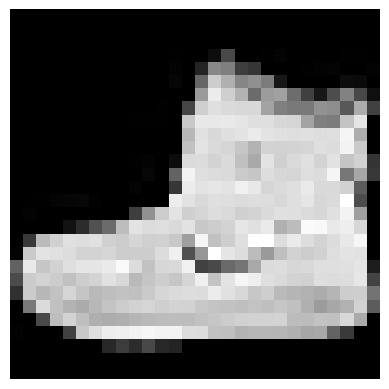

In [4]:
# Lets Take a look at the first train image

plt.imshow(train[0][0].squeeze(),cmap='gray')
plt.axis(False)
plt.show()

In [5]:
print(f'There are {len(train.classes)} classes which are {train.classes}')

There are 10 classes which are ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
# Preparing the Dataloader to put our data into batches

from torch.utils.data import DataLoader

train_batches = DataLoader(dataset = train,
                           batch_size = 32,
                           shuffle = True,
                           )

test_batches = DataLoader(dataset = test,
                          batch_size = 32,
                          shuffle = False)

In [7]:
print(f'The size of the batches are {len(next(iter(next(iter(train_batches)))))}, there are {len(train_batches)} train batches and {len(test_batches)} test batches.')

The size of the batches are 32, there are 1875 train batches and 313 test batches.


In [8]:
# We can start building our Model, we are going to be replicating the TinyVGG architecture
from torch import nn
HIDDEN_UNITS = 10

class TinyVGG_1(nn.Module):
  def __init__(self):
    super().__init__()


    self.conv_stack_0 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = HIDDEN_UNITS,kernel_size = 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = HIDDEN_UNITS,out_channels = HIDDEN_UNITS, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.conv_stack_1 = nn.Sequential(
        nn.Conv2d(in_channels = HIDDEN_UNITS, out_channels = HIDDEN_UNITS, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = HIDDEN_UNITS, out_channels = HIDDEN_UNITS, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 490 ,out_features = 10)
        )

  def forward(self, x):
    x = self.conv_stack_0(x)
    x = self.conv_stack_1(x)
    return self.Classifier(x)


model_1 = TinyVGG_1()

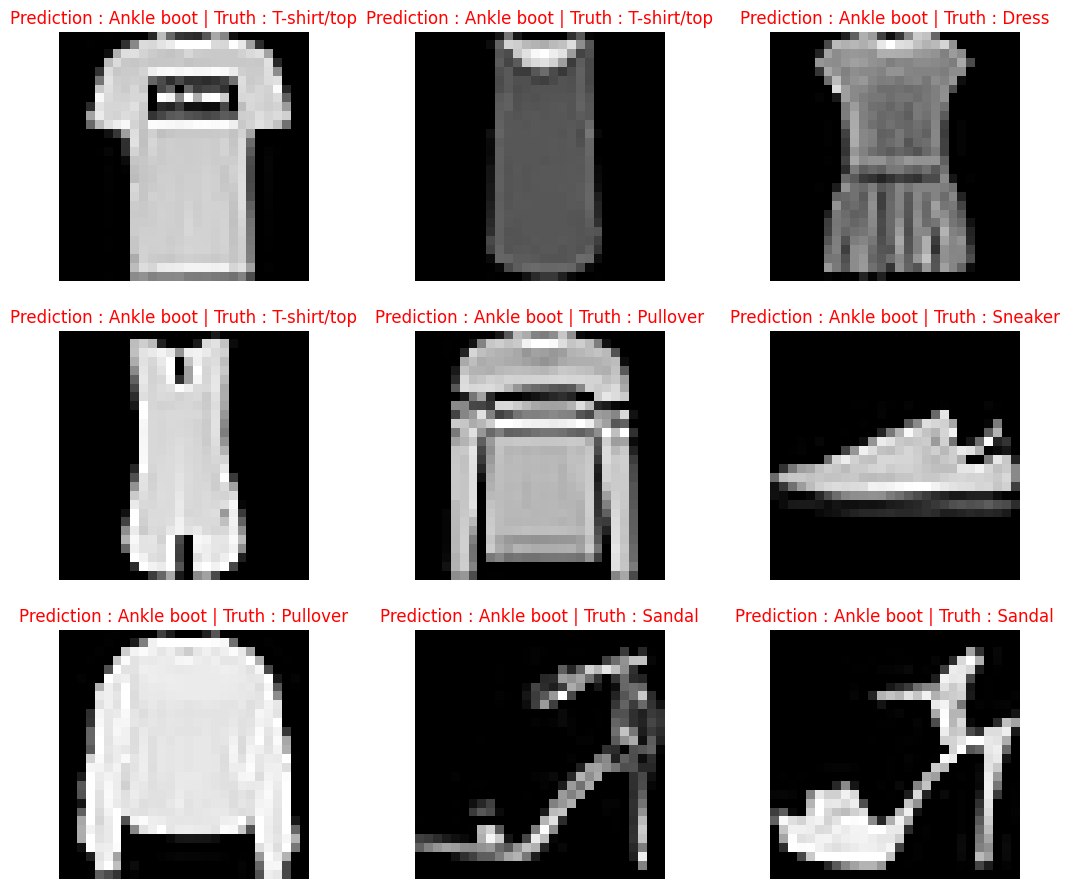

In [9]:
# Predictions from the model before the training loop using random weights
model_1.eval()
with torch.inference_mode():
  preds = []
  for i in range(1,10):
    logits = model_1(train[i][0].unsqueeze(dim=0))
    probs = torch.softmax(logits,1)
    pred = torch.argmax(probs,1)
    preds.append(pred)

fig = plt.figure(figsize = (13,11))
model_1.eval()
with torch.inference_mode():
  for i in range(1,10):
    logits = model_1(train[i][0].unsqueeze(dim=0))
    pred = logits.argmax(dim = 1)
    truth = train[i][1]
    fig.add_subplot(3,3,i)
    plt.imshow(train[i][0].squeeze(),cmap = 'gray')
    if pred == truth:
      plt.title(f'Prediction : {train.classes[pred]} | Truth : {train.classes[truth]}',c = 'green')
    else:
      plt.title(f'Prediction : {train.classes[pred]} | Truth : {train.classes[truth]}', c = 'red')
    plt.axis(False)

In [10]:
# Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
from torch.nn.modules.loss import CrossEntropyLoss
# loss fuction and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = .01
)

In [12]:
# create an accuracy function
def accuracy(predictions,actual):
  accuracy = predictions == actual

  return torch.sum(accuracy)/len(accuracy)

In [13]:
# Now for the training loop
EPOCHS = 50

# put the model on the device
model_1.to(device)

#run through train batches
for epoch in range(EPOCHS):

  model_1.train()

  train_loss = 0
  # enumerate through batches
  for i , (X,y) in enumerate(train_batches):

    X = X.to(device)
    y = y.to(device)

    # forward pass
    logits = model_1(X)

    # Calculate loss
    loss = loss_fn(logits,y)
    train_loss += loss_fn(logits,y)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # optimizer step
    optimizer.step()

  train_loss /= len(train_batches)

  # testing
  test_loss = 0
  test_accuracy = 0
  for X, y in test_batches:
    X = X.to(device)
    y = y.to(device)

    model_1.eval()

    with torch.inference_mode():
      test_logits = model_1(X)

    test_loss += loss_fn(test_logits,y)
    test_preds = test_logits.argmax(dim=1)
    test_accuracy += accuracy(test_preds,y)

  test_loss /= len(test_batches)
  test_accuracy /= len(test_batches)

  print(f'Epoch : {epoch} | Train Loss : {train_loss : .5f} | Test Loss : {test_loss : .5f} | Test Accuracy : {test_accuracy : .5f}')

Epoch : 0 | Train Loss :  1.89438 | Test Loss :  0.79055 | Test Accuracy :  0.73423
Epoch : 1 | Train Loss :  0.62604 | Test Loss :  0.54744 | Test Accuracy :  0.80391
Epoch : 2 | Train Loss :  0.47484 | Test Loss :  0.45445 | Test Accuracy :  0.83706
Epoch : 3 | Train Loss :  0.41912 | Test Loss :  0.41490 | Test Accuracy :  0.85244
Epoch : 4 | Train Loss :  0.38703 | Test Loss :  0.39215 | Test Accuracy :  0.86142
Epoch : 5 | Train Loss :  0.36442 | Test Loss :  0.38296 | Test Accuracy :  0.85893
Epoch : 6 | Train Loss :  0.34736 | Test Loss :  0.35988 | Test Accuracy :  0.87550
Epoch : 7 | Train Loss :  0.33396 | Test Loss :  0.34500 | Test Accuracy :  0.87630
Epoch : 8 | Train Loss :  0.32328 | Test Loss :  0.35728 | Test Accuracy :  0.87171
Epoch : 9 | Train Loss :  0.31375 | Test Loss :  0.33864 | Test Accuracy :  0.88089
Epoch : 10 | Train Loss :  0.30593 | Test Loss :  0.33410 | Test Accuracy :  0.87869
Epoch : 11 | Train Loss :  0.29874 | Test Loss :  0.34357 | Test Accuracy :

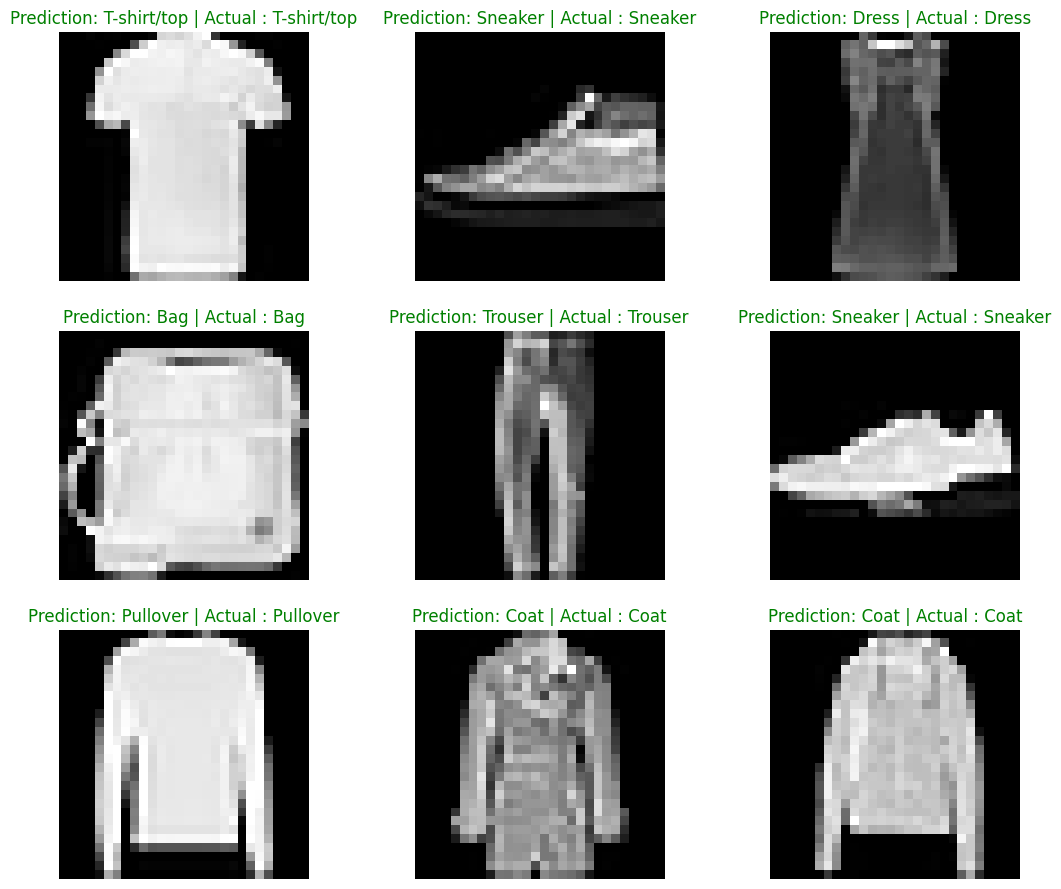

In [14]:
fig = plt.figure(figsize = (13,11))
model_1.eval()
with torch.inference_mode():
  for i in range(1,10):
    rand = torch.randint(1,len(test),size = (1,),dtype = torch.int)[0]
    logits = model_1(test[rand][0].to(device).unsqueeze(dim=0))
    test_pred = logits.argmax(dim=1)
    real = test[rand][1]
    fig.add_subplot(3,3,i)
    plt.imshow(test[rand][0].squeeze(dim=0),cmap = 'gray')

    if test_pred == real:
      plt.title(f'Prediction: {test.classes[test_pred]} | Actual : {test.classes[real]}', c='green')
    else:
      plt.title(f'Prediction: {test.classes[test_pred]} | Actual : {test.classes[real]}', c = 'red')

    plt.axis(False)

  plt.show()

<ipython-input-18-d47a360a96c9>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix = confmat(torch.tensor(test_preds),torch.tensor(test_actuals),)


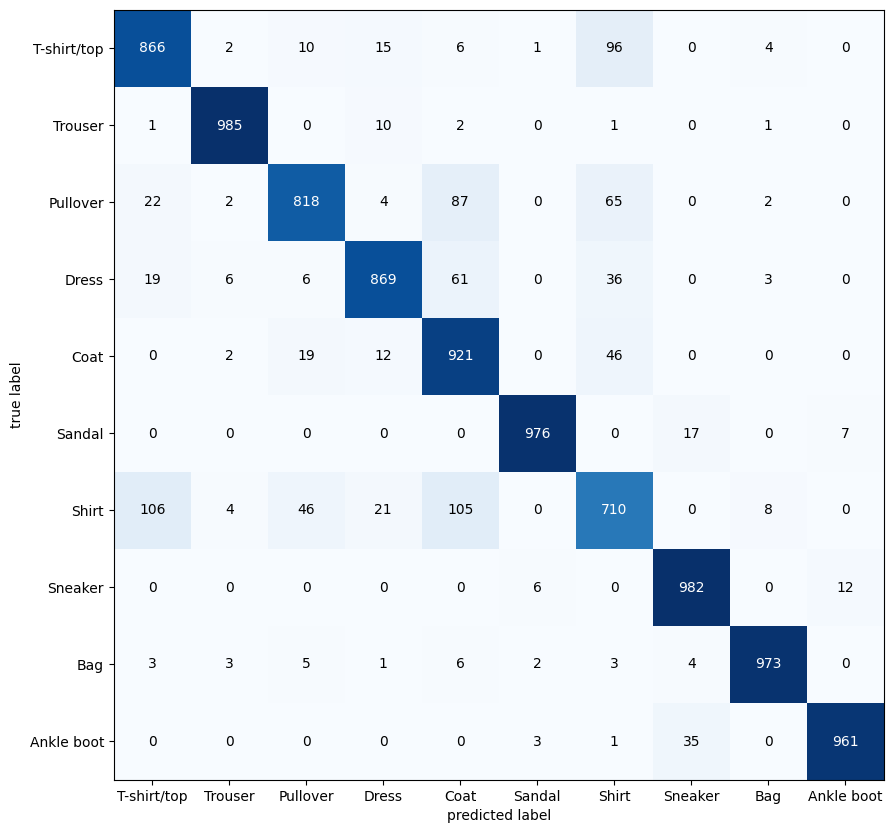

In [18]:
# Plotting a confusion matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task = 'multiclass',num_classes = 10,)

test_preds = torch.empty(0)
test_actuals = torch.empty(0)

model_1.eval()
with torch.inference_mode():
  for X , y in test_batches:
    X = X.to(device)
    y = y.to(device)

    logits = model_1(X)
    test_preds = torch.cat((test_preds,logits.argmax(dim=1).to('cpu')),0)
    test_actuals = torch.cat((test_actuals,y.to('cpu')),0)


matrix = confmat(torch.tensor(test_preds),torch.tensor(test_actuals),)
fig,ax = plot_confusion_matrix(matrix.numpy(),figsize = (10,10))

ticks = np.arange(0,len(train.classes),1)

ax.set_xticks(ticks,train.classes)
ax.set_yticks(ticks,train.classes)

plt.show()

The confusion matrix shows that our model struggles with the shirt label. While looking a few images and the class labels, it's obvious that the data some of the data labels have overlap that is confusing the model. For example it predicts T-shirt/top when the acutal is a shirt. The model's accuracy levels out at 40-50 epochs at around 90.5%, increasing epochs doesn't seem to lower the test loss or accuracy much or at all. Way's we could improve the model would be to adjust the hyperparameters in the conv and maxpooling layers as well as creating a deeper neural net.  